In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from mediawiki import MediaWiki
wikipedia = MediaWiki()
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [390]:
#regular expression to find the username regex = r'(\w+\s)?(?=[(]\btalk\b[)])'
#unable to capture usernames with spaces like 'Jirka Dl (talk)'
def find_user(text):
    user_str = re.findall(r'(\w+\s)?(?=[(]\btalk\b[)])',text)
    if len(user_str) ==0:
        user_str = re.findall(r'(\w+\s)?(?=[(]\btalk |\b[)])',text) #if (talk | ) is present
    elif(len(user_str)==0):#regular expression to find username if it is IP address
        user_str = re.findall(r'(?>(?>([a-f0-9]{1,4})(?>:(?1)){7}|(?!(?:.*[a-f0-9](?>:|$)){8,})((?1)(?>:(?1)){0,6})?::(?2)?)|(?>(?>(?1)(?>:(?1)){5}:|(?!(?:.*[a-f0-9]:){6,})(?3)?::(?>((?1)(?>:(?1)){0,4}):)?)?(25[0-5]|2[0-4][0-9]|1[0-9]{2}|[1-9]?[0-9])(?>\.(?4)){3}))',text) #if username is IPV4 address
    if len(user_str) == 0:
        user = 'Anonymous'
    else:
        user = user_str[0]
    return user
#regular expression to extract time stamp of comment, regex = r'\d{2}:\d{2},\s\d{2}\D+\d{4}'
# eg. 17:57, 15 March 2022
def find_time(text):
    time_str = re.findall(r'\d{2}:\d{2},\s\d{2}\s\D{3,9}?\s\d{4}',text)
    try:
        if len(time_str) == 0:
            date_time = None
        #elif any(short_month in time_str[0] for short_month in ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']):
        #   date_time = None
        else:
            date_time = datetime.strptime(time_str[-1],'%H:%M, %d %B %Y')
    except Exception as e:
        print("Error in find_time: ",e)
        date_time = None
    return date_time

In [357]:
climate_change_page_list=[
    'Talk:Climate_change',
    'Talk:Climate_change/Archive_90',
    'Talk:Climate_change/Archive_89',
    'Talk:Climate_change/Archive_88',
    'Talk:Climate_change/Archive_87',
    'Talk:Climate_change/Archive_86',
    'Talk:Climate_change/Archive_85',
    'Talk:Climate_change/Archive_84',
    'Talk:Climate_change/Archive_83',
    'Talk:Climate_change/Archive_82',
    'Talk:Climate_change/Archive_81',
    'Talk:Climate_change/Archive_80',
    'Talk:Climate_change/Archive_79',
    'Talk:Climate_change/Archive_78',
    'Talk:Climate_change/Archive_77',
    'Talk:Climate_change/Archive_76',
    'Talk:Climate_change/Archive_75',
    'Talk:Climate_change/Archive_74',
    'Talk:Climate_change/Archive_73',
    'Talk:Climate_change/Archive_72',
    'Talk:Climate_change/Archive_71',
    'Talk:Climate_change/Archive_70',
]

In [391]:
def wiki_page_to_df(page_list):
    df = pd.DataFrame(columns=['Topic','Comment','User','Date_Time'])
    for page in page_list:
        content = wikipedia.page(page).content
        content_topic_split = str.split(content,sep='\n==')
        content_topic_comment_split = [str.split(text,sep='==\n') for text in content_topic_split]
        user_level_comment_split = []
        for i in range(1,len(content_topic_comment_split)):
            #Appending topic,#splitting comments by user
            user_level_comment_split.append([content_topic_comment_split[i][0],str.split(content_topic_comment_split[i][1],sep='(UTC)')])
        for i in range(len(user_level_comment_split)):
          topic = user_level_comment_split[i][0]
          #list[] is topic level split, list[][] is all comments in that topic, list[][][] is user level split
          #list[i][0] is the topic, list[i][j] is all the comments, list[i][j][k] is the comment by single user
          for j in range(len(user_level_comment_split[i][1])):
            user = find_user(user_level_comment_split[i][1][j])
            date_time = find_time(user_level_comment_split[i][1][j])
            comment = user_level_comment_split[i][1][j]
            df = df.append({'Topic':topic,'Comment':comment,'User':user,'Date_Time':date_time},ignore_index=True)  
    return df

In [397]:
climate_talk_current_and_archive_70_to_90 = wiki_page_to_df(climate_change_page_list)

Error in find_time:  time data '17:11, 14 Dec 2019' does not match format '%H:%M, %d %B %Y'


In [399]:
#replacing \n with space
climate_talk_current_and_archive_70_to_90['Comment'] = climate_talk_current_and_archive_70_to_90['Comment'].str.replace('\n',' ')
#drop rows with empty space comments
climate_talk_current_and_archive_70_to_90 = climate_talk_current_and_archive_70_to_90[climate_talk_current_and_archive_70_to_90['Comment'].str.len()>0]
climate_talk_current_and_archive_70_to_90 = climate_talk_current_and_archive_70_to_90[climate_talk_current_and_archive_70_to_90['Comment'].str.strip() != '']

Topic  \
0                   Adding content on plant-based diet    
1                   Adding content on plant-based diet    
2                   Adding content on plant-based diet    
3                   Adding content on plant-based diet    
4                   Adding content on plant-based diet    
...                                                 ...   
6971   Interwiki link to quiz specific to this article    
6972   Interwiki link to quiz specific to this article    
6973                            External Links Section    
6974                            External Links Section    
6975                            External Links Section    

                                                Comment          User  \
0     Femke deleted the following content I added as...     Efbrazil    
1       It's a blog without even a byline. While I w...        Femke    
2      I'm fine removing "need to". To update the 14...     Efbrazil    
3      Sorry folks, but I'm sceptical about this bei...       HiLo48    
4      Well, over 80% of all agricultural land is us...     Efbrazil    
...                                                 ...           ...   
6971  Thanks for taking the time to review the quiz....     guyvan52    
6972                                                        Anonymous   
6973  Probably should delete most or all external li...  Everlasting    
6974    Just an idea:  You could move some of the ed...     guyvan52    
6975                                                        Anonymous   

               Date_Time  
0    2022-03-15 17:57:00  
1    2022-03-15 18:52:00  
2    2022-03-15 21:42:00  
3    2022-03-15 22:45:00  
4    2022-03-15 21:42:00  
...                  ...  
6971                 NaT  
6972                 NaT  
6973                 NaT  
6974                 NaT  
6975                 NaT  

[6976 rows x 4 columns]

In [410]:
#sentiment analysis
analyser = SentimentIntensityAnalyzer()
climate_talk_current_and_archive_70_to_90['compound'] = climate_talk_current_and_archive_70_to_90['Comment'].apply(lambda x: analyser.polarity_scores(x)['compound'])
climate_talk_current_and_archive_70_to_90['neg'] = climate_talk_current_and_archive_70_to_90['Comment'].apply(lambda x: analyser.polarity_scores(x)['neg'])
climate_talk_current_and_archive_70_to_90['neu'] = climate_talk_current_and_archive_70_to_90['Comment'].apply(lambda x: analyser.polarity_scores(x)['neu'])
climate_talk_current_and_archive_70_to_90['pos'] = climate_talk_current_and_archive_70_to_90['Comment'].apply(lambda x: analyser.polarity_scores(x)['pos'])

In [ ]:
climate_talk_current_and_archive_70_to_90.to_csv('climate_talk_current_and_archive_70_to_90.csv')

In [55]:
loaded_df = pd.read_csv('climate_talk_current_and_archive_70_to_90.csv')

In [56]:
#removing rows with topics having less than 5 comments
loaded_df_clean = loaded_df['Topic'].value_counts()>4
clean_index = loaded_df_clean[loaded_df_clean==True].index

In [57]:
clean_df = loaded_df[loaded_df['Topic'].isin(clean_index)]

In [109]:
#converting column Date_Time to datetime type
clean_df['Date_Time'] = pd.to_datetime(clean_df['Date_Time'])
#converting Column User,topic and comment to string type
clean_df['User'] = clean_df['User'].astype(str)
clean_df['Topic'] = clean_df['Topic'].astype(str)
clean_df['Comment'] = clean_df['Comment'].astype(str)

In [110]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5295 entries, 388 to 351
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  5295 non-null   int64         
 1   Topic       5295 non-null   object        
 2   Comment     5295 non-null   object        
 3   User        5295 non-null   object        
 4   Date_Time   3546 non-null   datetime64[ns]
 5   compound    5295 non-null   float64       
 6   neg         5295 non-null   float64       
 7   neu         5295 non-null   float64       
 8   pos         5295 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 542.7+ KB


In [111]:
#sorting the dataframe by sentiment score
#clean_df = clean_df.sort_values(by=['compound'],ascending=False)
#grouping the dataframe by topic and finding the average sentiment score
clean_df_grouped_topic = clean_df.groupby('Topic',as_index=False).mean()
clean_df_grouped_topic = clean_df_grouped_topic.sort_values(by=['compound'],ascending=False)

<AxesSubplot:xlabel='Topic'>

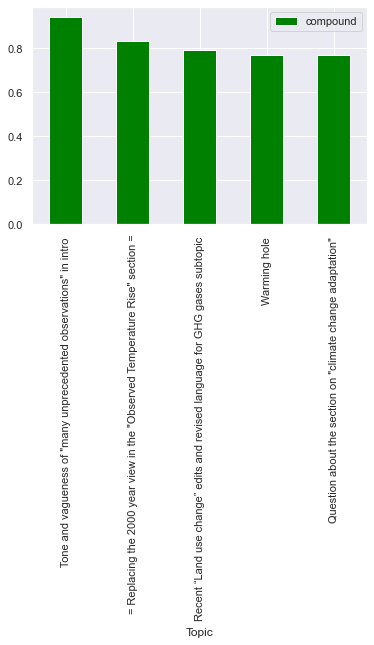

In [112]:
top_5_positive_topics = clean_df_grouped_topic[:5]
top_5_negative_topics = clean_df_grouped_topic[-5:]
#plotting top 5 positive topics
top_5_positive_topics.plot(kind='bar',x='Topic',y='compound',color='green')
#plotting top 5 negative topics
top_5_negative_topics.plot(kind='bar',x='Topic',y='compound',color='red')

In [113]:
#grouping the dataframe by user and finding the average sentiment score
clean_df_grouped_user = clean_df.groupby('User',as_index=False).mean()
clean_df_grouped_user = clean_df_grouped_user.sort_values(by=['compound'],ascending=False)
#top 5 positive users
top_5_positive_users = clean_df_grouped_user[:5]
#top 5 negative users
top_5_negative_users = clean_df_grouped_user[-5:]

<AxesSubplot:xlabel='User'>

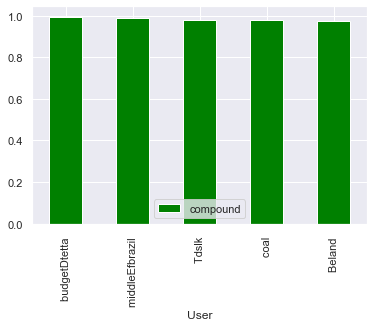

In [114]:
#plotting top 5 positive users
top_5_positive_users.plot(kind='bar',x='User',y='compound',color='green')
#plotting top 5 negative users
top_5_negative_users.plot(kind='bar',x='User',y='compound',color='red')

In [119]:
#timeseries plot of sentiment score of user 'budgetDtetta'
budgetDtetta_df = clean_df[clean_df['User']=='budgetDtetta']
print(budgetDtetta_df)
budgetDtetta_df = budgetDtetta_df.sort_values(by=['Date_Time'])
budgetDtetta_df.plot(kind='line',x='Date_Time',y='compound')

Empty DataFrame
Columns: [Unnamed: 0, Topic, Comment, User, Date_Time, compound, neg, neu, pos]
Index: []


<AxesSubplot:xlabel='Date_Time'>

In [125]:
#plotting the sentiment analysis grouped by topic, top 5 positive topics and top 5 negative topics using seaborn
sns.set(style="darkgrid")
sns.set(font_scale=1.5)
sns.barplot(x="compound", y="Topic", data=clean_df_grouped_topic.head(5).append(clean_df_grouped_topic.tail(5)), color="b")

<AxesSubplot:xlabel='compound', ylabel='Topic'>

In [124]:
clean_df_grouped_topic[5:-5]

Topic  Unnamed: 0  compound  \
194              Removed sentence, further explanatin       1706.0  0.767060   
282                       = 15. Modern colour scheme =      3720.5  0.745633   
27                                              Blurb       3372.5  0.741350   
168             Proposed changes to land use subtopic       3917.0  0.735436   
169                   Proposed changes to paragraph 2        133.0  0.723080   
..                                                 ...         ...       ...   
187                                  Reference errors       4173.0 -0.163645   
41             Consider talking more about the future       2001.5 -0.198325   
279                         = 1. Ocean acidification =      3630.0 -0.199240   
230   Shouldn't we be covering climate change exagg...       362.0 -0.208300   
266                                        Your chart       4982.5 -0.262564   

          neg       neu       pos  
194  0.022800  0.831800  0.145200  
282  0.019000  0.816333  0.164833  
27   0.015833  0.851833  0.132333  
168  0.016818  0.897545  0.085545  
169  0.041800  0.845400  0.112800  
..        ...       ...       ...  
187  0.072545  0.860455  0.066909  
41   0.089375  0.824375  0.086000  
279  0.060800  0.878000  0.061200  
230  0.108444  0.818333  0.073222  
266  0.064357  0.907643  0.028071  

[387 rows x 6 columns]

In [9]:
#Wordcloud visualization of the comments
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
#word tokeinzing the comments
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords,
                        min_font_size=10).generate(' '.join(loaded_df['Comment']))
                        
plt.figure(figsize = (10, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('wordcloud.png') 
plt.show()

In [448]:
#most active users
most_active_users = climate_talk_current_and_archive_70_to_90['User'].value_counts().sort_values(ascending=False)
most_active_users.head(10)
print(climate_talk_current_and_archive_70_to_90[climate_talk_current_and_archive_70_to_90['User']==''].User)

59       
61       
67       
77       
80       
       ..
6709     
6803     
6839     
6866     
6899     
Name: User, Length: 649, dtype: object


In [452]:
#Bag words visualization of comments in scatterplot
from wordcloud import WordCloud

c:\Users\bablu\miniconda3\envs\sds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


00 00  00 01  00 02  00 03  00 04  00 05  00 06  00 07  00 08  00 09  ...  \
0      0      0      0      0      0      0      0      0      0      0  ...   
1      0      0      0      0      0      0      0      0      0      0  ...   
2      0      0      0      0      0      0      0      0      0      0  ...   
3      0      0      0      0      0      0      0      0      0      0  ...   
4      0      0      0      0      0      0      0      0      0      0  ...   

   zooms reliably  zzz ppp  ºc increase  ºc ipcc  ánd people  ánd request  \
0               0        0            0        0           0            0   
1               0        0            0        0           0            0   
2               0        0            0        0           0            0   
3               0        0            0        0           0            0   
4               0        0            0        0           0            0   

   ürge vorsatz  אלכסנדר סעודה  סעודה talk  ᴢxᴄᴠʙɴᴍ 10  
0             0              0           0           0  
1             0              0           0           0  
2             0              0           0           0  
3             0              0           0           0  
4             0              0           0           0  

[5 rows x 193170 columns]

In [418]:
sub_df_topic_compound = climate_talk_current_and_archive_70_to_90[['Topic','compound']]

In [425]:
avg_df = sub_df_topic_compound.groupby('Topic')['compound'].mean()

In [426]:
avg_df.sort_values(ascending=False,inplace=True)

Text(0, 0.5, 'Sentiment')

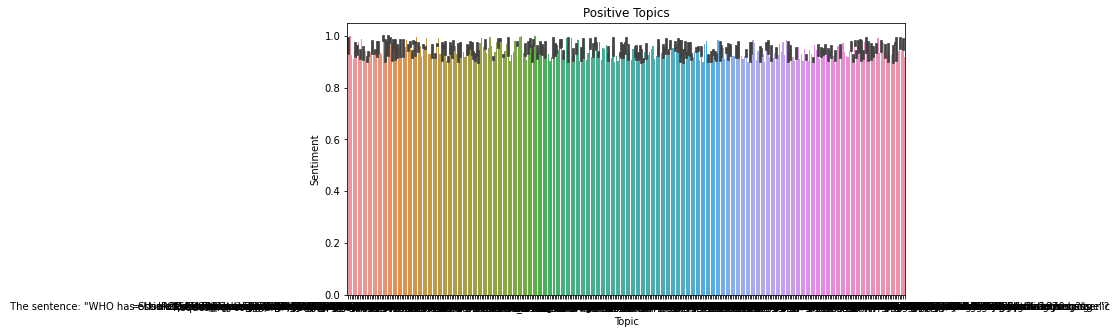

In [429]:
#plotting the logarithm barplot of top negative topics
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Topic',y='compound',data=sub_df_topic_compound[sub_df_topic_compound['compound']>0.9],ax=ax)
ax.set_title('Positive Topics')
ax.set_xlabel('Topic')
ax.set_ylabel('Sentiment')


Text(0, 0.5, 'Sentiment')

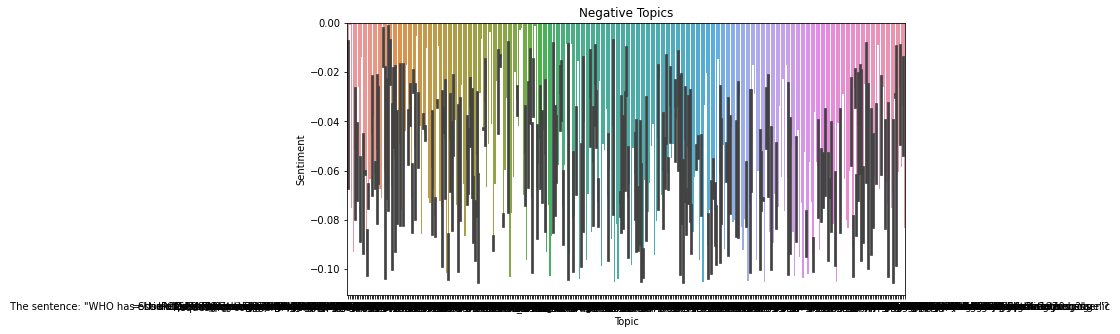

In [434]:
#plotting the logarithm barplot of top negative topics
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Topic',y=np.log(sub_df_topic_compound[sub_df_topic_compound['compound']>0.9]['compound']),data=sub_df_topic_compound[sub_df_topic_compound['compound']>0.9],ax=ax)
ax.set_title('Negative Topics')
ax.set_xlabel('Topic')
ax.set_ylabel('Sentiment')
